In [1]:
import numpy as np
import aipy as a
from hera_cal import omni
import hera_qm.ant_metrics as ant_metrics
reload(ant_metrics)

<module 'hera_qm.ant_metrics' from '/Users/jsdillon/anaconda2/lib/python2.7/site-packages/hera_qm-0.0.0-py2.7.egg/hera_qm/ant_metrics.pyc'>

# Setup

In [2]:
verbose = True

pols = ['xx','xy','yx','yy']
JD = '2457757.47316'
#dataFileList = ['/data4/paper/HERA2015/'+JD.split('.')[0]+'/zen.'+JD+'.'+pol+'.HH.uvc' for pol in pols]
dataFileList = ['../../HERA2015Data/'+JD.split('.')[0]+'/zen.'+JD+'.'+pol+'.HH.uvc' for pol in pols]

freqs = np.arange(.1,.2,.1/1024)    
aa = a.cal.get_aa('hsa7458_v001', freqs)
info = omni.aa_to_info(aa, pols=[pols[-1][0]], crosspols=[pols[-1]])
reds = info.get_reds()

metricsJSONFilename = JD+'.metrics.json'

# Main script for computing and saving metrics

In [3]:
am = ant_metrics.Antenna_Metrics(dataFileList, reds)
am.iterative_antenna_metrics_and_flagging(crossCut=5, deadCut=5, verbose=verbose)
am.save_antenna_metrics(metricsJSONFilename)

Altitude is not present in Miriad file, using known location values for HERA.
antenna number 112 has visibilities associated with it, but it has a position of (0,0,0)
Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


On iteration 0 we flag (64, 'y')
On iteration 1 we flag (22, 'y')
On iteration 2 we flag (81, 'y')
On iteration 2 we flag (81, 'x')
On iteration 3 we flag (64, 'x')
On iteration 4 we flag (22, 'x')


In [4]:
# #pyuvdata:
# %timeit -n 10 am.uvdata.get_data(65,81,'xx'); #forwards
# %timeit -n 10 am.uvdata.get_data(81,65,'xx'); #backwards

# #DataContainer:
# %timeit -n 10 am.data.get_data(65,81,'xx'); #forwards
# %timeit -n 10 am.data.get_data(81,65,'xx'); #backwards

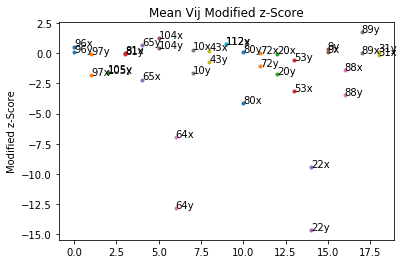

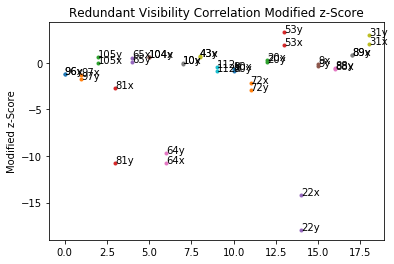

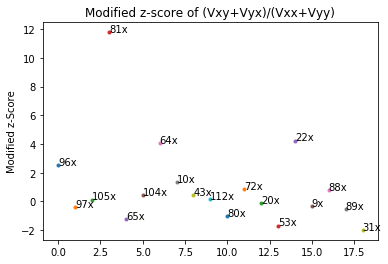

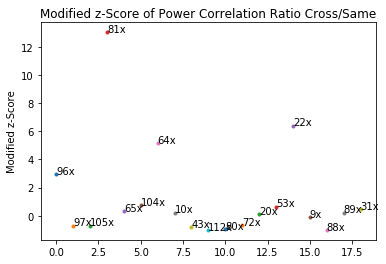

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 
metrics_results = ant_metrics.load_antenna_metrics(metricsJSONFilename)

ant_metrics.plot_metric(metrics_results['final_mod_z_scores']['meanVij'], 
                        title = 'Mean Vij Modified z-Score')
ant_metrics.plot_metric(metrics_results['final_mod_z_scores']['redCorr'],
                        title = 'Redundant Visibility Correlation Modified z-Score')
ant_metrics.plot_metric(metrics_results['final_mod_z_scores']['meanVijXPol'], antpols=['x'],
                        title = 'Modified z-score of (Vxy+Vyx)/(Vxx+Vyy)')
ant_metrics.plot_metric(metrics_results['final_mod_z_scores']['redCorrXPol'], antpols=['x'],
                        title = 'Modified z-Score of Power Correlation Ratio Cross/Same')